In [1]:
!pip install optuna

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 364.4/364.4 kB 6.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.5/233.5 kB 20.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.6/78.6 kB 7.9 MB/s eta 0:00:00


In [3]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split

import matplotlib.pyplot as plt

# Normalization techniques

In [4]:
# define transformations for the data

# Набір складається з 70,000 зображень, розділених на 60,000 тренувальних і 10,000 тестових зображень.
# Зображення є чорно-білими. Розмір кожного зображення — 28x28 пікселів. Кожен піксель представлений значенням від 0 (білий) до 255 (чорний).

# Перед завантаженням створимо об’єкт transform, що буде містити трансформації, які ми застосуємо до кожного зображення, а саме:
    # - перетворення зображення на тензор;
    # - приведення до середнього значення та стандартного відхилення значень, що репрезентують цей набір даних.

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))  # mean and standard deviation for MNIST
])

# download the complete MNIST data set
full_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)

# split the data set into training and validation
train_size = int(0.8 * len(full_dataset))
val_size = len(full_dataset) - train_size
train_dataset, val_dataset = random_split(full_dataset, [train_size, val_size])

# create a test data set
test_dataset = datasets.MNIST(root='./data', train=False, download=True, transform=transform)

# determine the batch size
batch_size = 64

# create data loaders
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

print(f"Train set size: {len(train_dataset)}")
print(f"Validation set size: {len(val_dataset)}")
print(f"Test set size: {len(test_dataset)}")
print(f"Number of batches in train_loader: {len(train_loader)}")

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 9.91M/9.91M [00:00<00:00, 19.9MB/s]


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 28.9k/28.9k [00:00<00:00, 611kB/s]


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 1.65M/1.65M [00:00<00:00, 5.43MB/s]


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 4.54k/4.54k [00:00<00:00, 4.86MB/s]

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw

Train set size: 48000
Validation set size: 12000
Test set size: 10000
Number of batches in train_loader: 750


In [5]:
# Визначимо архітектуру нашої базової нейронної мережі.
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(784, 512)
        self.fc2 = nn.Linear(512, 512)
        self.fc3 = nn.Linear(512, 10)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        return self.fc3(x)

In [6]:
# no regularization

model = Net()
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters())

num_epochs = 3

train_losses = []
train_accs = []

val_losses = []
val_accs = []

for epoch in range(num_epochs):
    model.train()
    train_loss = 0
    train_correct = 0
    train_total = 0

    for batch_idx, (data, target) in enumerate(train_loader):
        optimizer.zero_grad()
        output = model(data.view(data.size(0), -1))
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        _, predicted = output.max(1)
        train_total += target.size(0)
        train_correct += predicted.eq(target).sum().item()

    train_loss /= len(train_loader)
    train_accuracy = 100. * train_correct / train_total

    train_losses.append(train_loss)
    train_accs.append(train_accuracy)

    # validation step
    model.eval()
    val_loss = 0
    val_correct = 0
    val_total = 0

    with torch.no_grad():
        for data, target in val_loader:
            output = model(data.view(data.size(0), -1))
            loss = criterion(output, target)
            val_loss += loss.item()
            _, predicted = output.max(1)
            val_total += target.size(0)
            val_correct += predicted.eq(target).sum().item()

    val_loss /= len(val_loader)
    val_accuracy = 100. * val_correct / val_total

    val_losses.append(val_loss)
    val_accs.append(val_accuracy)

    print(f'Epoch [{epoch+1}/{num_epochs}]')
    print(f'Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.2f}%')
    print(f'Val Loss: {val_loss:.4f}, Val Accuracy: {val_accuracy:.2f}%')
    print('-' * 50)

Epoch [1/3]
Train Loss: 0.2220, Train Accuracy: 93.16%
Val Loss: 0.1224, Val Accuracy: 96.28%
--------------------------------------------------
Epoch [2/3]
Train Loss: 0.0921, Train Accuracy: 97.09%
Val Loss: 0.0970, Val Accuracy: 97.14%
--------------------------------------------------
Epoch [3/3]
Train Loss: 0.0691, Train Accuracy: 97.76%
Val Loss: 0.0925, Val Accuracy: 97.30%
--------------------------------------------------


In [7]:
def visualize_training_history(train_losses, train_accs, val_losses, val_accs):
    epochs = range(1, len(train_losses) + 1)

    plt.figure(figsize=(12, 5))

    # loss plot
    plt.subplot(1, 2, 1)
    plt.plot(epochs, train_losses, 'b-', label='Train Loss')
    plt.plot(epochs, val_losses, 'r-', label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    # accuracy plot
    plt.subplot(1, 2, 2)
    plt.plot(epochs, train_accs, 'b-', label='Train Accuracy')
    plt.plot(epochs, val_accs, 'r-', label='Validation Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.tight_layout()
    plt.show()

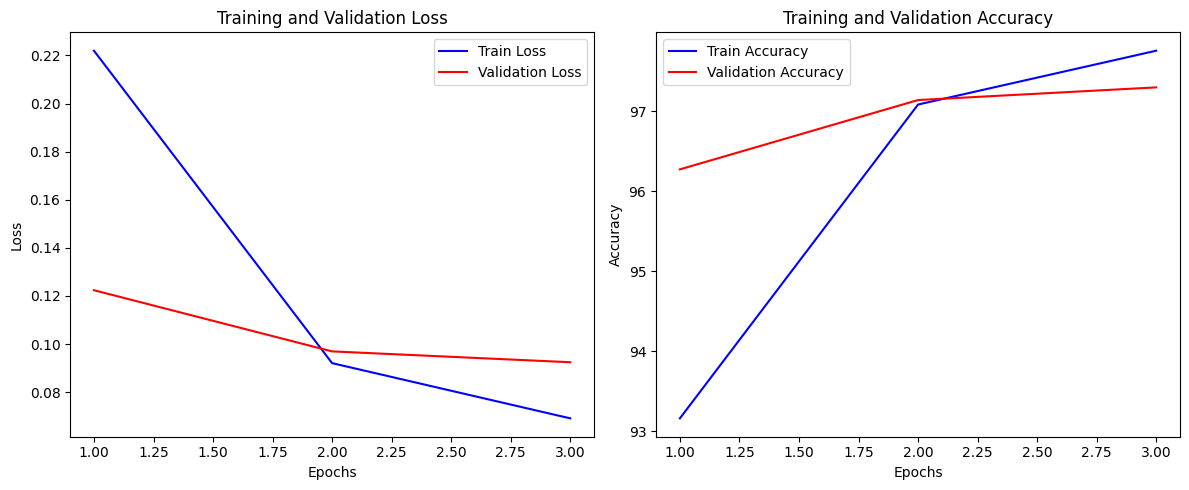

In [8]:
visualize_training_history(train_losses, train_accs, val_losses, val_accs)

Epoch [1/3]
Train Loss: 0.2268, Train Accuracy: 93.05%
Val Loss: 0.1523, Val Accuracy: 95.24%
--------------------------------------------------
Epoch [2/3]
Train Loss: 0.1144, Train Accuracy: 96.54%
Val Loss: 0.1071, Val Accuracy: 96.69%
--------------------------------------------------
Epoch [3/3]
Train Loss: 0.0951, Train Accuracy: 96.96%
Val Loss: 0.1172, Val Accuracy: 96.49%
--------------------------------------------------


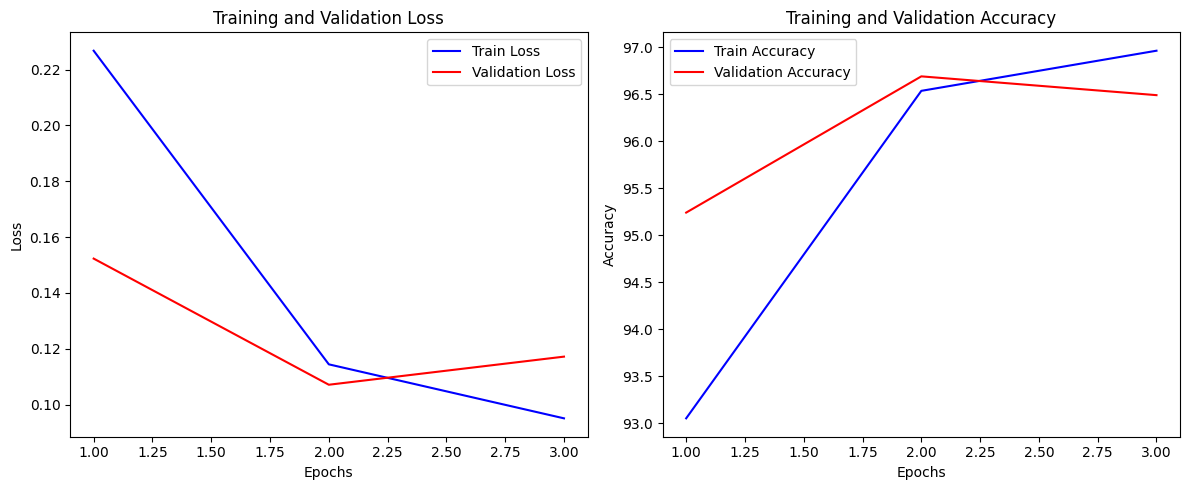

In [9]:
# Тренувальні втрати постійно знижуються, а валідаційні спочатку зменшуються, але потім стабілізуються і трохи зростають після 3-ї епохи.
# Тренувальна точність стабільно зростає, досягаючи майже 99%. Валідаційна точність швидко покращується в перші 2-3 епохи, потім стабілізується.

# Розходження між тренувальними й валідаційними метриками після 3-ї епохи вказує на перенавчання.

# Тепер додамо регуляризацію. У цьому випадку є сенс додати L2 регуляризацію:
    # вона допомагає запобігти перенавчанню, яке ми спостерігали на графіках;
    # у PyTorch L2 регуляризація легко додається через параметр weight_decay оптимізатора;
    # L2 стимулює модель мати менші ваги, що часто покращує узагальнення;
    # L2 добре працює з Adam, який використовується в цьому коді.

# У наступному коді зверніть увагу на визначення оптимізатора: саме в ньому ми задаємо параметр weight_decay. Значення, передане у weight_decay, відповідає гіперпараметру λ L2 регуляризації.

# L2 regularization

model = Net()
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), weight_decay=1e-3)

num_epochs = 3

train_losses = []
train_accs = []

val_losses = []
val_accs = []

for epoch in range(num_epochs):
    model.train()
    train_loss = 0
    train_correct = 0
    train_total = 0

    for batch_idx, (data, target) in enumerate(train_loader):
        optimizer.zero_grad()
        output = model(data.view(data.size(0), -1))
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        _, predicted = output.max(1)
        train_total += target.size(0)
        train_correct += predicted.eq(target).sum().item()

    train_loss /= len(train_loader)
    train_accuracy = 100. * train_correct / train_total

    train_losses.append(train_loss)
    train_accs.append(train_accuracy)

    # validation step
    model.eval()
    val_loss = 0
    val_correct = 0
    val_total = 0

    with torch.no_grad():
        for data, target in val_loader:
            output = model(data.view(data.size(0), -1))
            loss = criterion(output, target)
            val_loss += loss.item()
            _, predicted = output.max(1)
            val_total += target.size(0)
            val_correct += predicted.eq(target).sum().item()

    val_loss /= len(val_loader)
    val_accuracy = 100. * val_correct / val_total

    val_losses.append(val_loss)
    val_accs.append(val_accuracy)

    print(f'Epoch [{epoch+1}/{num_epochs}]')
    print(f'Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.2f}%')
    print(f'Val Loss: {val_loss:.4f}, Val Accuracy: {val_accuracy:.2f}%')
    print('-' * 50)

visualize_training_history(train_losses, train_accs, val_losses, val_accs)

Розрив між тренувальними й валідаційними кривими зменшився, що свідчить про кращу генералізацію моделі.



Хоча модель краще генералізує, максимальна досягнута точність трохи нижча, що є типовим компромісом при застосуванні регуляризації. Криві втрат показують, що модель навчається дещо повільніше, але більш стабільно.



Загалом новий результат демонструє кращий баланс між навчанням на тренувальних даних і здатністю узагальнювати на валідаційних даних.

In [ ]:
# early stopping
# приклад моделі з ранньою зупинкою та подивимось, на якій епосі зупиниться тренування.
# Зверніть увагу на параметр patience. Він визначає кількість епох навчання, протягом яких модель може не показувати покращення, перш ніж навчання буде зупинено.
# Це допомагає запобігти перенавчанню, даючи моделі шанс подолати тимчасові плато в навчанні.
# Якщо продуктивність на валідаційному наборі не покращується протягом вказаної кількості епох, навчання припиняється, і зберігається найкраща знайдена модель.

model = Net()
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters())
best_val_loss = float('inf')
patience = 2
counter = 0

train_losses = []
train_accs = []
val_losses = []
val_accs = []

for epoch in range(3):
    model.train()
    train_loss = 0
    train_correct = 0
    train_total = 0
    for batch_idx, (data, target) in enumerate(train_loader):
        optimizer.zero_grad()
        output = model(data.view(data.size(0), -1))
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        _, predicted = output.max(1)
        train_total += target.size(0)
        train_correct += predicted.eq(target).sum().item()

    train_loss /= len(train_loader)
    train_acc = 100. * train_correct / train_total

    model.eval()
    val_loss = 0
    val_correct = 0
    val_total = 0
    with torch.no_grad():
        for data, target in val_loader:
            output = model(data.view(data.size(0), -1))
            val_loss += criterion(output, target).item()
            _, predicted = output.max(1)
            val_total += target.size(0)
            val_correct += predicted.eq(target).sum().item()

    val_loss /= len(val_loader)
    val_acc = 100. * val_correct / val_total

    # save results
    train_losses.append(train_loss)
    train_accs.append(train_acc)
    val_losses.append(val_loss)
    val_accs.append(val_acc)

    print(f'Epoch {epoch}: Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}%, '
          f'Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.2f}%')

    if val_loss < best_val_loss:
        best_val_loss = val_loss
        counter = 0
    else:
        counter += 1
        if counter >= patience:
            print(f"Early stopping at epoch {epoch}")
            break

Epoch 0: Train Loss: 0.2198, Train Acc: 93.28%, Val Loss: 0.1386, Val Acc: 95.74%
Epoch 1: Train Loss: 0.0925, Train Acc: 97.13%, Val Loss: 0.1073, Val Acc: 96.90%
Epoch 2: Train Loss: 0.0617, Train Acc: 98.00%, Val Loss: 0.1049, Val Acc: 97.09%


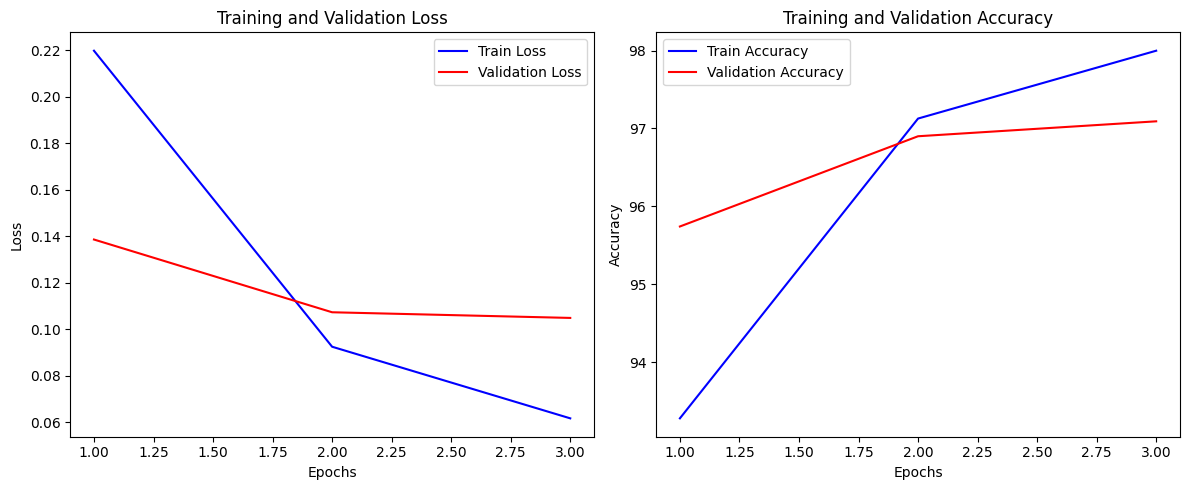

In [ ]:
visualize_training_history(train_losses, train_accs, val_losses, val_accs)

Бачимо, що тренувальні показники постійно покращуються. Валідаційні показники покращуються до 2-ї епохи, потім коливаються. Ознаки перенавчання з'являються після 2-ї епохи. Early stopping спрацював на 4-й епосі, запобігаючи подальшому перенавчанню.



Отже, модель швидко досягла високої точності, але почала перенавчатися. Early stopping ефективно зупинив цей процес.

In [10]:
# Dropout — це техніка регуляризації, спрямована на запобігання перенавчанню нейронних мереж шляхом випадкового вимикання нейронів під час навчання.
# - На кожній ітерації навчання (train mode) з імовірністю p (часто від 0.2 до 0.5) кожен нейрон у мережі може бути тимчасово вимкнений, тобто його вихід встановлюється на нуль.
# Це означає, що на кожній ітерації навчання різні набори нейронів можуть бути вимкнені.
# Важливо зазначити, що ваги, пов'язані з вимкненими нейронами, не оновлюються під час цієї ітерації.
# Під час оцінки (evaluation mode) всі нейрони активні, і Dropout не вимикає жоден з них.
# Переваги:
    # Запобігання перенавчанню. Випадкове вимикання нейронів запобігає тому, щоб модель надто сильно покладалася на окремі нейрони. Це змушує модель розподіляти навчання рівномірніше по всій мережі.
    # Покращення узагальнення. Dropout дозволяє моделі краще узагальнювати нові дані, оскільки знижує ризик перенавчання на тренувальних даних.

class NetWithDropout(nn.Module):
    def __init__(self):
        super(NetWithDropout, self).__init__()
        self.fc1 = nn.Linear(784, 512)
        self.dropout1 = nn.Dropout(0.2)
        self.fc2 = nn.Linear(512, 512)
        self.dropout2 = nn.Dropout(0.2)
        self.fc3 = nn.Linear(512, 10)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = self.dropout1(x)
        x = torch.relu(self.fc2(x))
        x = self.dropout2(x)
        return self.fc3(x)
# Тут ми додали два шари Dropout з імовірністю занулення нейронів, рівній 20%.

In [11]:
# dropout

model = NetWithDropout()
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters())

train_losses = []
train_accs = []
val_losses = []
val_accs = []

for epoch in range(3):
    model.train()
    train_loss = 0
    train_correct = 0
    train_total = 0
    for batch_idx, (data, target) in enumerate(train_loader):
        optimizer.zero_grad()
        output = model(data.view(data.size(0), -1))
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        _, predicted = output.max(1)
        train_total += target.size(0)
        train_correct += predicted.eq(target).sum().item()

    train_loss /= len(train_loader)
    train_acc = 100. * train_correct / train_total

    model.eval()
    val_loss = 0
    val_correct = 0
    val_total = 0
    with torch.no_grad():
        for data, target in val_loader:
            output = model(data.view(data.size(0), -1))
            val_loss += criterion(output, target).item()
            _, predicted = output.max(1)
            val_total += target.size(0)
            val_correct += predicted.eq(target).sum().item()

    val_loss /= len(val_loader)
    val_acc = 100. * val_correct / val_total

    # save results
    train_losses.append(train_loss)
    train_accs.append(train_acc)
    val_losses.append(val_loss)
    val_accs.append(val_acc)

    print(f'Epoch {epoch}: Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}%, '
          f'Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.2f}%')

Epoch 0: Train Loss: 0.2460, Train Acc: 92.38%, Val Loss: 0.1399, Val Acc: 95.66%
Epoch 1: Train Loss: 0.1211, Train Acc: 96.26%, Val Loss: 0.1067, Val Acc: 96.83%
Epoch 2: Train Loss: 0.0942, Train Acc: 97.07%, Val Loss: 0.0920, Val Acc: 97.35%


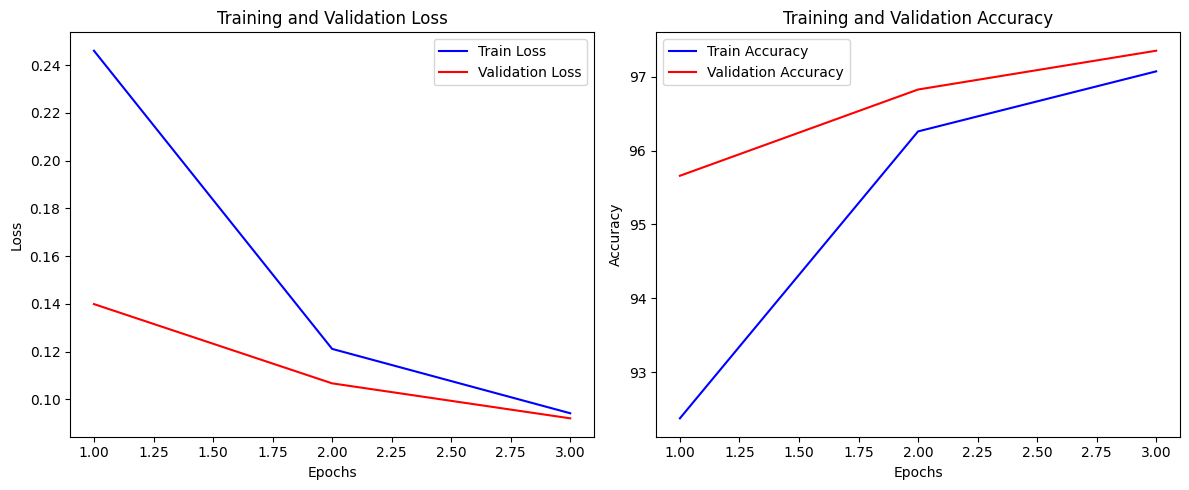

In [12]:
visualize_training_history(train_losses, train_accs, val_losses, val_accs)

Тренувальні показники постійно покращуються. Валідаційні показники загалом покращуються, але з коливаннями. Фінальна валідаційна точність є найвищою серед усіх наших експериментів. Розрив між тренувальною та валідаційною точністю зменшився.



Dropout сповільнив навчання, але покращив генералізацію, зменшив перенавчання, дозволивши моделі навчатися довше.



Отже, Dropout ефективно запобіг перенавчанню, дозволивши моделі досягти кращих результатів на валідаційній вибірці.

In [13]:
class NetWithBN(nn.Module):
    def __init__(self):
        super(NetWithBN, self).__init__()
        self.fc1 = nn.Linear(784, 256)
        self.bn1 = nn.BatchNorm1d(256)
        self.fc2 = nn.Linear(256, 256)
        self.bn2 = nn.BatchNorm1d(256)
        self.fc3 = nn.Linear(256, 10)

    def forward(self, x):
        x = torch.relu(self.bn1(self.fc1(x)))
        x = torch.relu(self.bn2(self.fc2(x)))
        return self.fc3(x)

Epoch 0: Train Loss: 0.2064, Train Acc: 93.94%, Val Loss: 0.1063, Val Acc: 96.83%
Epoch 1: Train Loss: 0.0901, Train Acc: 97.19%, Val Loss: 0.0876, Val Acc: 97.38%
Epoch 2: Train Loss: 0.0594, Train Acc: 98.09%, Val Loss: 0.0828, Val Acc: 97.59%


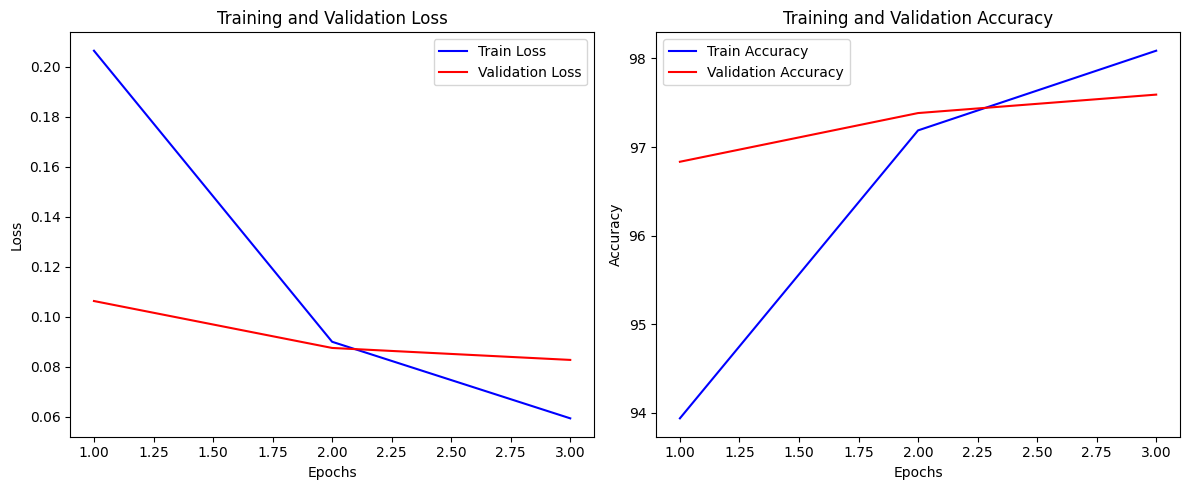

In [14]:
# BN

model = NetWithBN()
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters())

train_losses = []
train_accs = []
val_losses = []
val_accs = []

for epoch in range(3):
    model.train()
    train_loss = 0
    train_correct = 0
    train_total = 0
    for batch_idx, (data, target) in enumerate(train_loader):
        optimizer.zero_grad()
        output = model(data.view(data.size(0), -1))
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        _, predicted = output.max(1)
        train_total += target.size(0)
        train_correct += predicted.eq(target).sum().item()

    train_loss /= len(train_loader)
    train_acc = 100. * train_correct / train_total

    model.eval()
    val_loss = 0
    val_correct = 0
    val_total = 0
    with torch.no_grad():
        for data, target in val_loader:
            output = model(data.view(data.size(0), -1))
            val_loss += criterion(output, target).item()
            _, predicted = output.max(1)
            val_total += target.size(0)
            val_correct += predicted.eq(target).sum().item()

    val_loss /= len(val_loader)
    val_acc = 100. * val_correct / val_total

    # save results
    train_losses.append(train_loss)
    train_accs.append(train_acc)
    val_losses.append(val_loss)
    val_accs.append(val_acc)

    print(f'Epoch {epoch}: Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}%, '
          f'Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.2f}%')


visualize_training_history(train_losses, train_accs, val_losses, val_accs)

Спостерігаємо швидше початкове навчання: висока точність на навчальній вибірці була досягнута вже на епосі 0. Дуже висока кінцева тренувальна точність (99.70%).



BatchNorm прискорив початкове навчання, дозволив досягти вищої тренувальної точності, стабілізував валідаційні показники.



Тренувальна точність тут вища, ніж у моделі з Dropout. Валідаційна точність подібна до моделі з Dropout. І звісно, ця модель має кращі результати, ніж у базової моделі без регуляризації.



Отже, BatchNorm ефективно прискорив навчання та стабілізував процес, дозволяючи досягти високої точності як на тренувальному, так і на валідаційному наборах. Однак, є ознаки легкого перенавчання (розрив між тренувальною та валідаційною точністю більший, ніж у моделі з dropout).





# Hyperparameter optimization

- Study (дослідження) - це процес оптимізації, спрямований на пошук найкращих гіперпараметрів. Містить цільову функцію та налаштування для оптимізації.


    study = optuna.create_study(direction='minimize')



- Trial (спроба) — це окрема оцінка цільової функції з конкретним набором гіперпараметрів. Кожен Trial є частиною Study і представляє одну ітерацію процесу оптимізації.


- Objective function (цільова функція) - Це функція, яку потрібно оптимізувати.
Вона приймає Trial як аргумент і повертає значення, яке потрібно мінімізувати або максимізувати.


    def objective(trial):
        x = trial.suggest_float('x', -10, 10)
        return (x - 2) ** 2



Ці концепції взаємодіють таким чином:

Study створює множину Trials.
Кожен Trial викликає цільову функцію з різними гіперпараметрами.


Optuna використовує результати Trials для покращення вибору гіперпараметрів у наступних ітераціях.

    study.optimize(objective, n_trials=100)

## Створення оптимізаційного завдання

Оптимізаційне завдання в Optuna створюється шляхом визначення Study та цільової функції. Ось основні кроки:

    # create a Study
    study = optuna.create_study(direction='minimize')# or 'maximize'

    # objective function definition
    def objective(trial):
    # optimization logic
        return score

    # run optimization
    study.optimize(objective, n_trials=100)

### Цільова функція — це ключовий елемент оптимізації. Вона повинна:
- приймати параметр trial;
- використовувати trial для вибору гіперпараметрів;
- повертати метрику, яку ми хочемо оптимізувати.


### Вибір простору пошуку для гіперпараметрів

Optuna надає різні методи для визначення простору пошуку гіперпараметрів:

- trial.suggest_float(): для дійсних чисел,
- trial.suggest_int(): для цілих чисел,
- trial.suggest_categorical(): для категорійних змінних,
- trial.suggest_loguniform(): для логарифмічно розподілених дійсних чисел.


    # A float number between 0 to 1
    x = trial.suggest_float('x', 0, 1)

    # An integer number between 1 to 10
    n = trial.suggest_int('n', 1, 10)

    # Selection from categories
    algorithm = trial.suggest_categorical('algorithm', ['SGD', 'Adam', 'RMSprop'])

    # Logarithmically distributed number
    learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-1)



Важливо обрати відповідний діапазон і розподіл для кожного гіперпараметра, базуючись на вашому розумінні моделі та даних.


Ці елементи разом формують основу для створення ефективного оптимізаційного завдання в Optuna. Фреймворк автоматично досліджуватиме визначений простір пошуку, намагаючись знайти найкращу комбінацію гіперпараметрів для мінімізації (або максимізації) значення, яке повертає цільова функція.

### Методи оптимізації в Optuna


Optuna пропонує ряд ефективних методів оптимізації, кожен з яких має свої особливості й переваги для різних типів задач машинного навчання.

- Tree-structured Parzen Estimator (TPE)

 - Основний алгоритм оптимізації в Optuna.
 - Баєсівський підхід, який моделює ймовірність хороших і поганих результатів для кожного гіперпараметра.
 - Ефективний для оптимізації складних просторів пошуку.
 - Добре працює як з числовими, так і з категорійними параметрами.

        study = optuna.create_study(sampler=optuna.samplers.TPESampler())


- Випадковий пошук (Random Search)

 - Простий, але часто ефективний метод.
 - Вибирає гіперпараметри випадково з визначеного простору пошуку.
 - Корисний для початкового дослідження простору гіперпараметрів.

        study = optuna.create_study(sampler=optuna.samplers.RandomSampler())



- CmaEsSampler

 - Реалізує алгоритм CMA-ES (Covariance Matrix Adaptation Evolution Strategy).
 - Ефективний для оптимізації неперервних параметрів.

        study = optuna.create_study(sampler=optuna.samplers.CmaEsSampler())


- NSGAIISampler

 - Реалізує алгоритм NSGA-II для багатоцільової оптимізації.
 - Корисний, коли потрібно оптимізувати кілька цілей одночасно.

          study = optuna.create_study(sampler=optuna.samplers.NSGAIISampler())

- GridSampler

 - Здійснює повний перебір усіх можливих комбінацій гіперпараметрів.
 - Корисний для невеликих просторів пошуку.

        search_space = {"x": [1, 2, 3], "y": [4, 5, 6]}
        study = optuna.create_study(sampler=optuna.samplers.GridSampler(search_space))



Optuna дозволяє легко перемикатися між різними методами оптимізації, що дає можливість експериментувати й вибирати найбільш відповідний метод для конкретної задачі.



Вибір методу оптимізації залежить від специфіки задачі, розміру та складності простору пошуку, обчислювальних ресурсів та інших факторів. TPE є хорошим вибором за замовчуванням, але експериментування з різними методами може привести до кращих результатів у конкретних випадках.

In [15]:
import optuna

In [16]:
# Спершу модифікуємо нашу baseline-модель так, щоб у ній використовувались Dropout і BatchNorm.
class Net(nn.Module):
    def __init__(self, dropout_rate, use_batchnorm):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(784, 512)
        self.fc2 = nn.Linear(512, 512)
        self.fc3 = nn.Linear(512, 10)
        self.dropout = nn.Dropout(dropout_rate)
        self.use_batchnorm = use_batchnorm
        if use_batchnorm:
            self.bn1 = nn.BatchNorm1d(512)
            self.bn2 = nn.BatchNorm1d(512)

    def forward(self, x):
        x = x.view(-1, 784)
        x = self.fc1(x)
        if self.use_batchnorm:
            x = self.bn1(x)
        x = torch.relu(x)
        x = self.dropout(x)
        x = self.fc2(x)
        if self.use_batchnorm:
            x = self.bn2(x)
        x = torch.relu(x)
        x = self.dropout(x)
        return self.fc3(x)

In [19]:
# Створимо функцію objective, яка:
    # 1. Вибирає гіперпараметри за допомогою Optuna.
    # 2. Створює і тренує модель з цими гіперпараметрами.
    # 3. Реалізує просту версію early stopping.
    # 4. Оцінює модель на валідаційному наборі даних.
# Використаємо Optuna для пошуку оптимальних гіперпараметрів, максимізуючи точність на валідаційному наборі.

def objective(trial):
    # determine hyperparameters for optimization
    lr = trial.suggest_float('lr', 1e-5, 1e-1, log=True)
    dropout_rate = trial.suggest_float('dropout_rate', 0.1, 0.5)
    use_batchnorm = trial.suggest_categorical('use_batchnorm', [True, False])
    batch_size = trial.suggest_categorical('batch_size', [32, 64, 128, 256])

    # create a model with selected hyperparameters
    model = Net(dropout_rate, use_batchnorm)

    # training settings 0.46
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    optimizer = optim.Adam(model.parameters(), lr=lr)
    criterion = nn.CrossEntropyLoss()

    # model training
    model.train()
    for epoch in range(10):  # let's limit it to 10 epochs for speed
        for batch_idx, (data, target) in enumerate(train_loader):
            optimizer.zero_grad()
            output = model(data)
            loss = criterion(output, target)
            loss.backward()
            optimizer.step()

        # Early stopping
        if epoch > 2 and loss.item() > prev_loss:
            break
        prev_loss = loss.item()

    # model evaluation
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for data, target in DataLoader(test_dataset, batch_size=1000):
            output = model(data)
            _, predicted = torch.max(output.data, 1)
            total += target.size(0)
            correct += (predicted == target).sum().item()
 # 0.46
    accuracy = correct / total
    return accuracy

In [29]:
# Враховуйте, що пошук гіперпараметрів — не швидкий процес. Ви можете запустити пошук, наприклад, в обід і подивитися на результати ввечері після роботи.
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=10)

print('Number of finished trials:', len(study.trials))
print('Best trial:')
trial = study.best_trial
print('  Value: ', trial.value)
print('  Params: ')
for key, value in trial.params.items():
    print('    {}: {}'.format(key, value))

[I 2024-12-12 03:41:08,130] A new study created in memory with name: no-name-8a6d9fe9-7301-475f-8906-de53afcc30e8
[I 2024-12-12 03:43:06,512] Trial 0 finished with value: 0.9595 and parameters: {'lr': 3.63304587643974e-05, 'dropout_rate': 0.4746330460558037, 'use_batchnorm': True, 'batch_size': 64}. Best is trial 0 with value: 0.9595.
[I 2024-12-12 03:44:41,502] Trial 1 finished with value: 0.9796 and parameters: {'lr': 0.0008509973824426657, 'dropout_rate': 0.3113875220781819, 'use_batchnorm': True, 'batch_size': 256}. Best is trial 1 with value: 0.9796.
[I 2024-12-12 03:47:48,023] Trial 2 finished with value: 0.2974 and parameters: {'lr': 0.019010966128240478, 'dropout_rate': 0.24699695872892527, 'use_batchnorm': False, 'batch_size': 32}. Best is trial 1 with value: 0.9796.
[I 2024-12-12 03:50:39,563] Trial 3 finished with value: 0.9799 and parameters: {'lr': 0.000268333191995655, 'dropout_rate': 0.19468760264599078, 'use_batchnorm': False, 'batch_size': 64}. Best is trial 3 with val

Number of finished trials: 10
Best trial:
  Value:  0.9801
  Params: 
    lr: 0.0007874291555640354
    dropout_rate: 0.102392568507719
    use_batchnorm: True
    batch_size: 64


<ipython-input-30-2092a92d03af>:3: ExperimentalWarning:

plot_optimization_history is experimental (supported from v2.2.0). The interface can change in the future.



<Figure size 1000x600 with 0 Axes>

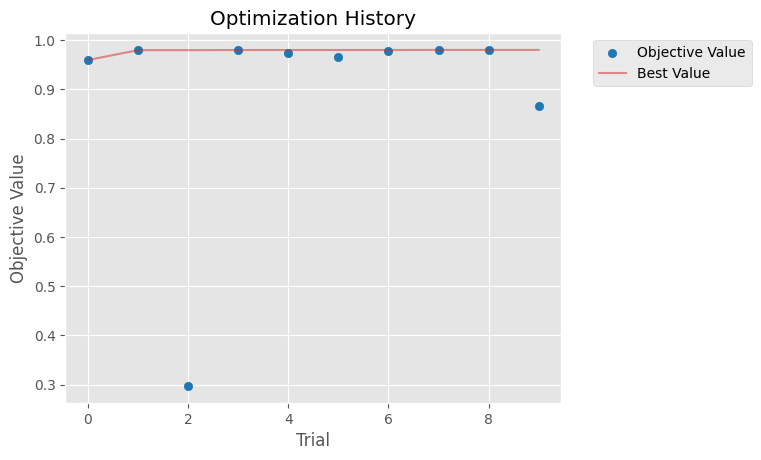

In [30]:
# 1. Optimization history plot  / Візуалізуємо результати нашого пошуку.
plt.figure(figsize=(10, 6))
optuna.visualization.matplotlib.plot_optimization_history(study)
plt.title("Optimization History")
plt.show()

Графік історії оптимізації показує, як змінювалося найкраще значення цільової функції з кожним trial.



На графіку видно, що процес оптимізації швидко досяг дуже високих значень цільової функції і залишався стабільним протягом усіх випробувань. Це свідчить про те, що Optuna ефективно знайшла оптимальні гіперпараметри на ранніх стадіях пошуку, і подальші ітерації не привели до значних покращень.

<ipython-input-31-d1fa5a47ad7f>:3: ExperimentalWarning:

plot_param_importances is experimental (supported from v2.2.0). The interface can change in the future.



<Figure size 1000x600 with 0 Axes>

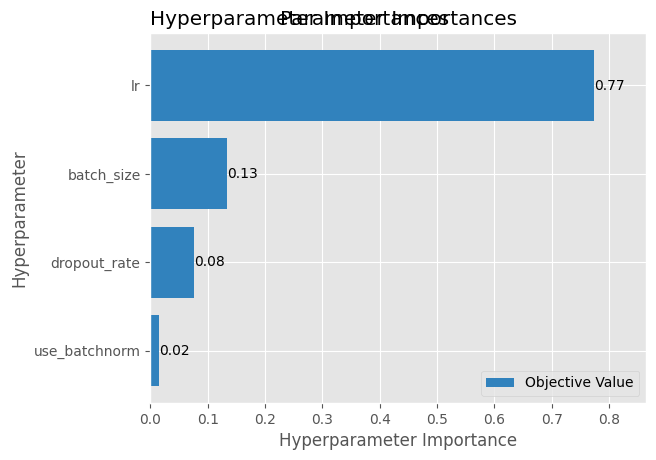

In [31]:
# 2. Parameter importance plot  / Далі виведемо графік важливості параметрів, який показує, які параметри мали найбільший вплив на результат.
plt.figure(figsize=(10, 6))
optuna.visualization.matplotlib.plot_param_importances(study)
plt.title("Parameter Importances")
plt.show()

Бачимо відносну важливість різних гіперпараметрів для оптимізації цільової функції. Найбільш впливовими виявилися швидкість навчання (lr) з важливістю 0.50 і використання нормалізації батчів (use_batchnorm) з важливістю 0.35.

Розмір батчу (batch_size) і dropout_rate мали значно менший вплив — із важливістю 0.08 і 0.07 відповідно. Це вказує на те, що для покращення моделі варто зосередитись на налаштуванні швидкості навчання та використанні нормалізації батчів.

<ipython-input-32-76112ecce101>:3: ExperimentalWarning:

plot_parallel_coordinate is experimental (supported from v2.2.0). The interface can change in the future.



<Figure size 1000x600 with 0 Axes>

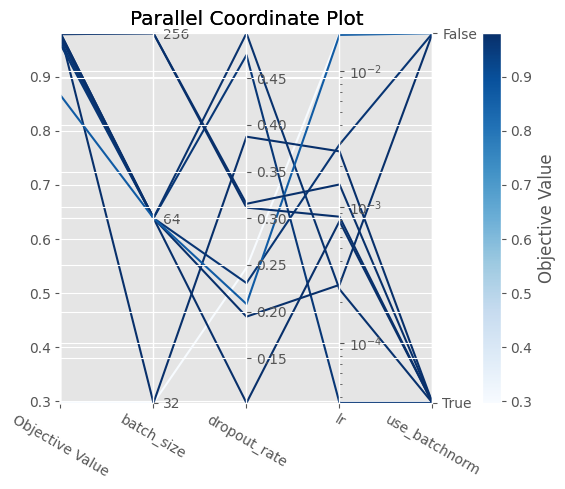

In [32]:
# 3. Parameters interaction plot
# Наступний паралельний координатний графік — взаємодії параметрів — дозволяє побачити взаємозв'язки між різними параметрами та цільовою функцією.
# Кожна лінія представляє окремий експеримент, а її колір відповідає значенню цільової функції.
plt.figure(figsize=(10, 6))
optuna.visualization.matplotlib.plot_parallel_coordinate(study)
plt.title("Parallel Coordinate Plot")
plt.show()

Найкращі результати (темно-сині лінії) досягаються при низьких значеннях швидкості навчання (lr). Використання нормалізації батчів також (use_batchnorm = True) частіше приводить до кращих результатів.

Бачимо, що розмір батчу (batch_size) і dropout_rate мають менш чіткий вплив на продуктивність.



Таким чином, найвищі значення цільової функції досягаються при комбінації низької швидкості навчання та використання нормалізації батчів. Це підтверджує висновки з попереднього аналізу важливості параметрів і доводить, що швидкість навчання та нормалізація батчів є ключовими факторами для оптимізації моделі.

<ipython-input-33-af1169519ffa>:3: ExperimentalWarning:

plot_slice is experimental (supported from v2.2.0). The interface can change in the future.



<Figure size 1000x600 with 0 Axes>

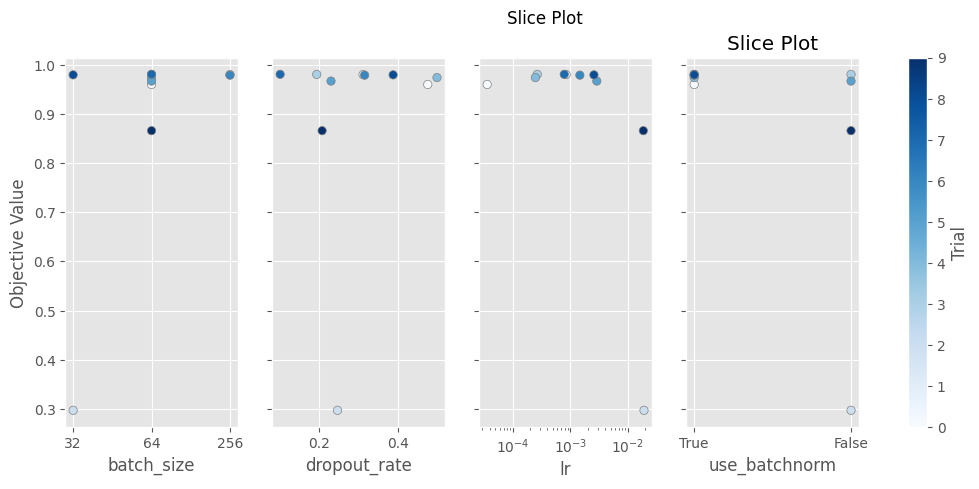

In [33]:
# 4. Parameter value distribution plot  / Графік розподілу значень параметрів показує, як значення окремих параметрів впливають на результат.
plt.figure(figsize=(10, 6))
optuna.visualization.matplotlib.plot_slice(study)
plt.title("Slice Plot")
plt.show()

Цей графік відображає вплив різних гіперпараметрів на цільову функцію:

- Розмір батчу batch_size має незначний вплив. Високі значення цільової функції досягаються при різних розмірах батчу.
- dropout_rate також має обмежений вплив. Хороші результати отримуються при різних значеннях dropout_rate.
- lr (швидкість навчання) — це найвпливовіший параметр. Найкращі результати досягаються при низьких значеннях lr. При високих значеннях lr продуктивність значно падає.
- use_batchnorm: використання нормалізації батчів (True) дає кращі та стабільніші результати порівняно з її відсутністю (False).


Ці спостереження узгоджуються з попередніми висновками, підкреслюючи важливість правильного налаштування швидкості навчання та використання нормалізації батчів для оптимізації моделі.



In [34]:
# 5. Interactive optimization plot  / Наступні 4 графіки є інтерактивною версією вищенаведених графіків з використанням бібліотеки plotly.
fig = optuna.visualization.plot_optimization_history(study)
fig.show()

In [35]:
# 6. Interactive parameter importance plot
fig = optuna.visualization.plot_param_importances(study)
fig.show()

In [36]:
# 7. Interactive interaction of parameters plot
fig = optuna.visualization.plot_parallel_coordinate(study)
fig.show()

In [37]:
# 8. Interactive parameter value distribution plot
fig = optuna.visualization.plot_slice(study)
fig.show()

Ці візуалізації надають цінну інформацію про процес оптимізації та допомагають зрозуміти, які параметри найбільше впливають на продуктивність моделі.





Отже, ми можемо зробити такі висновки.

Найкращий trial досяг значення 0.9826 (точність 98.26%), що є дуже високим показником для задачі класифікації.

Багато trials досягли результатів вище 97%, що свідчить про стабільність моделі й ефективність обраного підходу до оптимізації.

Оптимальне значення швидкості навчання виявилося досить низьким, що може вказувати на необхідність повільного, але стабільного навчання. Середнє значення Dropout близько 0.37 допомагає запобігти перенавчанню. Використання batch normalization виявилося корисним для покращення результатів. Менший розмір батчу (32) виявився оптимальним, що може сприяти кращій генералізації.



Optuna ефективно дослідила простір гіперпараметрів, знаходячи все кращі результати протягом процесу оптимізації.



Процес тривав близько 3 годин, що є прийнятним часом для глибокого дослідження простору гіперпараметрів.



Хоча досягнуто дуже високого результату, можливо, є потенціал для ще точнішого налаштування або дослідження додаткових гіперпараметрів.